The purpose of this notebook is to generate a figure which shows that for the ancestry-associated genes, only one of the guides shows any differential activity.

In [1]:
#Arguments/Parameters
workspace_bucket = Sys.getenv('WORKSPACE_BUCKET') #the workspace bucket that we will upload the output to
num.threads = 16 #Specify the number of CPUs you want to use. Some steps take a lot of compute.

In [2]:
#Load packages
library(tidyverse)
library(reshape2)

#Define functions
show_msg <- function(x){ 
    print(x)
    flush.console()
}

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




In [3]:
###All of this is hard-coded because I just need to make this figure really quickly.
###In the future it will be necessary to generalize the code

In [5]:
#Download the data
system(glue::glue("
cd /home/jupyter/Ancestry/gwas
gsutil cp gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514/internal-21q4_v9-achilles-guide-map.csv .
gsutil cp gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514/internal-21q4_v9-achilles-replicate-map.csv .
gsutil cp gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514/internal-21q4_v9-achilles-logfold-change.csv .
"))

In [3]:
#Load the data into R
setwd("/home/jupyter/Ancestry/gwas")
replicate.map = read.table("internal-21q4_v9-achilles-replicate-map.csv", header = T, sep = ",")
guide.map = read.table("internal-21q4_v9-achilles-guide-map.csv", header = T, sep = ",")
logfc = read.table("internal-21q4_v9-achilles-logfold-change.csv", header = T, sep = ",", check.names = FALSE)


In [5]:
#Load in the rfmix data
setwd('/home/jupyter/Ancestry/rfmix')
rfmix.file.list = list.files(path = ".", pattern = ".Q")
rfmix.file.list

#Compile it all into a single object
rfmix.data = NULL #create an empty object to hold the data
index = 0 #define the for loop index
for(file in rfmix.file.list){
    index = index + 1 #increase the index
    
    
    #Load in and format the data
    individual.chromosome = read.table(file, fill = TRUE) %>%
    rename("sample" = 1, "AFR" = 2, "AMR" = 3, "EAS" = 4, "EUR" = 5, "SAS" = 6) %>%
    select(-sample)
    
    
    
    #Add the data to the main data frame
    if(index == 1) {
        rfmix.data = individual.chromosome
    } else {
        rfmix.data = rfmix.data + individual.chromosome
    }
    
    
    
    #Divide the data by the number of chromosomes to get the ancestry fraction across the genome
    if(index == length(rfmix.file.list)) {
        rfmix.data = rfmix.data/length(rfmix.file.list)
    }
    
    
    
    #Re-add the sample names
    if(index == length(rfmix.file.list)){
        sample.names = read.table(file, fill = TRUE) %>%
        rename("sample" = 1) %>%
        pull(sample) 
        
    rfmix.data = rfmix.data %>%
        mutate(sample = sample.names, .before = "AFR")
    }
    
}

head(rfmix.data)

[1] "chr1.rfmix.output.rfmix.Q"  "chr10.rfmix.output.rfmix.Q"
 [3] "chr11.rfmix.output.rfmix.Q" "chr12.rfmix.output.rfmix.Q"
 [5] "chr13.rfmix.output.rfmix.Q" "chr14.rfmix.output.rfmix.Q"
 [7] "chr15.rfmix.output.rfmix.Q" "chr16.rfmix.output.rfmix.Q"
 [9] "chr17.rfmix.output.rfmix.Q" "chr18.rfmix.output.rfmix.Q"
[11] "chr19.rfmix.output.rfmix.Q" "chr2.rfmix.output.rfmix.Q" 
[13] "chr20.rfmix.output.rfmix.Q" "chr21.rfmix.output.rfmix.Q"
[15] "chr22.rfmix.output.rfmix.Q" "chr3.rfmix.output.rfmix.Q" 
[17] "chr4.rfmix.output.rfmix.Q"  "chr5.rfmix.output.rfmix.Q" 
[19] "chr6.rfmix.output.rfmix.Q"  "chr7.rfmix.output.rfmix.Q" 
[21] "chr8.rfmix.output.rfmix.Q"  "chr9.rfmix.output.rfmix.Q"

,sample,AFR,AMR,EAS,EUR,SAS
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ACH-000657,0.9601677273,0.0005504545,0.0063213636,0.03192409,0.0010363636
2,ACH-000617,0.0028859091,0.0204050000,0.0000000000,0.97557545,0.0011336364
3,ACH-000685,0.8539895455,0.0272740909,0.0395313636,0.07403591,0.0051686364
4,ACH-000632,0.0025995455,0.0009922727,0.0001513636,0.99553364,0.0007231818
5,ACH-000171,0.0007454545,0.0000000000,0.0010822727,0.99686682,0.0013054545
6,ACH-000863,0.0065409091,0.0000000000,0.0036922727,0.96728000,0.0224868182


In [14]:
#Merge the RFMix data with the cell lineage
setwd("/home/jupyter/Ancestry/gwas")
lineage.annotation = read.table('internal-22q1_v24-sample-info.csv', sep = ",", header = T, fill = TRUE) %>%
select(DepMap_ID, lineage) %>%
rename("sample" = DepMap_ID) %>%
inner_join(rfmix.data, by = "sample") %>%
mutate(ancestry = ifelse(AFR > 0.8, "AFR", 
                        ifelse(AMR > 0.8, "AMR",
                              ifelse(EAS > 0.8, "EAS",
                                    ifelse(EUR > 0.8, "EUR",
                                          ifelse(SAS > 0.8, "SAS", "Admixed"))))))

head(lineage.annotation)

Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
“EOF within quoted string”


,sample,lineage,AFR,AMR,EAS,EUR,SAS,ancestry
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,ACH-000001,ovary,0.0034077273,0.0036922727,0.0008009091,0.9915032,0.0005959091,EUR
2,ACH-000002,blood,0.0074231818,0.0000000000,0.0006659091,0.9873991,0.0045122727,EUR
3,ACH-000004,blood,0.0153395455,0.0007950000,0.0019813636,0.9759618,0.0059222727,EUR
4,ACH-000005,blood,0.0145381818,0.0014136364,0.0029336364,0.9743491,0.0067659091,EUR
5,ACH-000007,colorectal,0.0007550000,0.0004977273,0.0002004545,0.9966591,0.0018872727,EUR
6,ACH-000008,skin,0.0006354545,0.0000000000,0.0009890909,0.9968695,0.0015059091,EUR


In [5]:
#Load the cell line ancestry data into R
#All of this code is borrowed from the ancestry figure notebook. In the future it is probably better to just code that notebook so that it exports this dataset.

#Load in the sample names
paste({working_dir}, "/admixture", sep = "") %>% setwd()
sample.names = read.table('admixture.sample.header.for.plot', sep = "\t") %>%
pull(1)

#Load in lineage annotation
paste({working_dir}, "/admixture", sep = "") %>% setwd()
lineage.annotation = read.table('internal-21q3_v15-sample-info.csv', sep = ",", header = T) %>%
rename("depmap_id" = 1, "lineage" = 2)


#Load in the CCLE Projections
paste({working_dir}, "/admixture", sep = "") %>% setwd()
ccle.projections = read.table('merged.ccle.admixture.target.5.Q', sep = " ") %>%
mutate(depmap_id = sample.names) %>%
rename("EUR" = 1, "EAS" = 2, "AMR" = 3, "SAS" = 4, "AFR" = 5) %>% #These names are based on the assignments from the reference
mutate(lineage = depmap_id) %>%
mutate(lineage = plyr::mapvalues(lineage, from = lineage.annotation$depmap_id, to = lineage.annotation$lineage, warn_missing = FALSE))

#Print the head so that we can take a look at it.
head(ccle.projections)

max.ancestry = ccle.projections %>%
mutate(popmax = case_when(
                                EUR >= 0.8 ~ "European (EUR)",
                                EAS >= 0.8 ~ "East Asian (EAS)",
                                AMR >= 0.8 ~ "American (AMR)",
                                SAS >= 0.8 ~ "South Asian (SAS)",
                                AFR >= 0.8 ~ "African (AFR)")) %>%
mutate(popmax = replace_na(popmax, "Admixed")) %>%
select(depmap_id, lineage, popmax) 

head(max.ancestry)

,EUR,EAS,AMR,SAS,AFR,depmap_id,lineage
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,0.058376,0.841298,0.028906,0.013521,0.057898,ACH-000380,plasma_cell
2,0.036494,0.863657,0.032450,0.008646,0.058753,ACH-000321,blood
3,0.011415,0.010345,0.003088,0.964387,0.010765,ACH-000857,breast
4,0.888580,0.017735,0.028750,0.055862,0.009074,ACH-000883,central_nervous_system
5,0.898368,0.014906,0.025614,0.052141,0.008971,ACH-000936,ovary
6,0.915203,0.006926,0.029091,0.026713,0.022068,ACH-000290,lung


,depmap_id,lineage,popmax
,<chr>,<chr>,<chr>
1,ACH-000380,plasma_cell,East Asian (EAS)
2,ACH-000321,blood,East Asian (EAS)
3,ACH-000857,breast,South Asian (SAS)
4,ACH-000883,central_nervous_system,European (EUR)
5,ACH-000936,ovary,European (EUR)
6,ACH-000290,lung,European (EUR)


In [16]:
#Process a final dataset that has the ACH ID as the header and the 

#First, get the barcodes that correspond to CLSPN
guides.to.keep = guide.map %>%
mutate(gene = word(gene, 1)) %>%
filter(gene %in% "CLSPN") %>%
pull(sgrna)

guides.to.keep


#Now process the sgRNA dataset.
logfc.processed = logfc %>%
rename("sgrna" = 1) %>%
filter(sgrna %in% guides.to.keep) %>%
column_to_rownames(var="sgrna") %>%
t() %>%
data.frame() %>%
rownames_to_column(., "sgrna") %>%
mutate(sgrna = plyr::mapvalues(sgrna, from = replicate.map$replicate_ID, to = replicate.map$DepMap_ID, warn_missing = FALSE)) %>%
mutate(ancestry = sgrna, .after = sgrna) %>%
mutate(ancestry = plyr::mapvalues(ancestry, from = lineage.annotation$sample, to = lineage.annotation$ancestry, warn_missing = FALSE)) %>%
filter(ancestry %in% c("EUR", "EAS")) %>%
melt()

head(logfc.processed)

[1] "AACTACCTATGACAGTGCCG" "AGTTATCAAAAGGAACCACG" "ATAGTGCCATGGCATTTCCG"
[4] "CTTGAACCTGAAACCAACAG"

Using sgrna, ancestry as id variables



,sgrna,ancestry,variable,value
,<chr>,<chr>,<fct>,<dbl>
1,ACH-000948,EUR,AACTACCTATGACAGTGCCG,-0.725870376
2,ACH-000948,EUR,AACTACCTATGACAGTGCCG,-0.791364129
3,ACH-000323,EUR,AACTACCTATGACAGTGCCG,-1.121173240
4,ACH-000323,EUR,AACTACCTATGACAGTGCCG,-0.321636241
5,ACH-000520,EUR,AACTACCTATGACAGTGCCG,-1.355364975
6,ACH-000520,EUR,AACTACCTATGACAGTGCCG,0.007774243


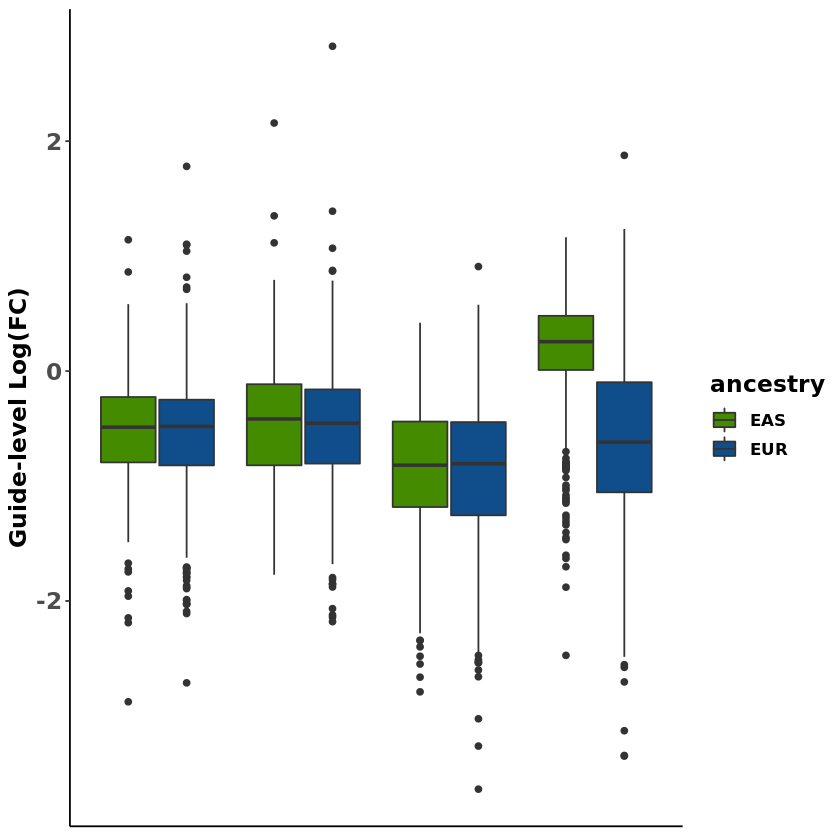

In [19]:
#Now plot the data
set.seed(42)
group.colors <- c("EAS" = "chartreuse4", "EUR" = "dodgerblue4") #Make the color vector

logfc.processed %>%
ggplot(aes(x = variable, y = value, fill = ancestry)) +
geom_boxplot(position=position_dodge(0.8)) +
scale_fill_manual(values = group.colors) +

theme_bw() +

theme(
panel.border = element_blank(), 
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
axis.line = element_line(color = "black")
) +

theme(
axis.text=element_text(size=12),
axis.title=element_text(size=14, face="bold")
) +

theme(
axis.text.x = element_text(face="bold", size=14),
axis.text.y = element_text(face="bold", size=14)
) +

theme(
panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(color = "black", size = 14, face = "bold"),
axis.title.y = element_text(color = "black", size = 14, face = "bold")
) +

theme(
axis.text=element_text(size = 12, face = "bold"),
axis.title=element_text(size = 14,face = "bold")
) +

theme(
legend.title = element_text(size = 14, face = "bold"),
legend.text = element_text(size = 10, face = "bold")
) +

theme(
axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)
) +

theme(
axis.title.x=element_blank(),
axis.text.x=element_blank(),
axis.ticks.x=element_blank()
) +

xlab("Gene") +
ylab("Guide-level Log(FC)")  

#Put the exported image into the google bucket
setwd("/home/jupyter/Ancestry/figures")
ggsave("ancestry_association_single_guide.pdf", width = 5, height = 3)
system(glue::glue("
cd /home/jupyter/Ancestry/figures
gsutil cp ancestry_association_single_guide.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))
